<p hidden>Here are some Latex definitions</p> 

$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\N}{\mathcal{N}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Mm}{\mathcal{M}}$

# TP 4 : Défloutage d'une image via la minimisation d'une fonction quadratique

L'objectif final de ce TP est de résoudre le problème suivant: étant donné l'image ci-dessous, qui est clairement floue, peut-on en extraire, ou disons reconstruire, une image plus nette?

| |
| --- |
| ![](images/comete_blur.png) |

Ce TP va consister en 3 parties :

1. Une partie *modélisation* où nous allons essayer de comprendre comment formuler notre problème mathématiquement. Nous allons voir qu'on peut se ramener à la minimisation d'une fonction quadratique. 
2. Une partie *optimisation* où nous allons résoudre une version simplifiée du problème, à l'aide de l'algorithme du gradient.
3. Une partie *application* où nous allons pouvoir résoudre notre problème.

Voici quelques commandes python dont vous pourrez avoir besoin:

| | Ici `np`=`numpy` et `la`=`numpy.linalg` |
|-|-|
|`np.random.randn(m,n)`| Génère une matrice aléatoire dans $\Mm_{m,n}(\RR)$ |
| `np.zeros((m,n))` | Génère une matrice nulle dans $\Mm_{m,n}(\RR)$ |
| `np.ones((m,n))` | Génère une matrice remplie de $1$ dans $\Mm_{m,n}(\RR)$ |
| `A.T` | Transposée de la matrice `A` |
| `A@B` | Produit entre deux matrices ou matrice/vecteur |
| `A*B` | Multiplie coefficient par coefficient le contenu de ces deux matrices/vecteurs |
| `np.sum(A)` | Renvoie la somme de tous les coefficients de `A` |
| `la.norm(A,2)` | Plus grande valeur singulière de `A` |
| `la.norm(A,-2)` | Plus petite valeur singulière de `A` |
| `la.norm(x)` | Norme Euclidienne du vecteur `x` |
| `print(f"Hello {x}")` | Affiche à l'écran `Hello 18` si `x=18` |
| `liste=[1,2,3]` | Une liste contenant les éléments 1,2,3 |
| `liste=[]` | Une liste vide |
| `liste.append(18)` | Ajoute `18` à la fin de la `liste` |



In [3]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
plt.set_cmap('gray') # Fixe la colormap à 'gray' pour afficher les images

<Figure size 640x480 with 0 Axes>

# I. Modélisation d'un problème de traitement d'image

## I.1. Une image = un vecteur

Commençons déjà par acquérir cette image floue:

In [4]:
y = np.load('data/photo.npy')

Pour un ordinateur, une image n'est rien d'autre qu'un *tableau* (array), où chaque pixel se voit attribué une valeur. Vous pouvez utiliser la fonction `type()` et l'attribut `.shape` pour déterminer le type et la dimension de l'objet `y` que l'on vient de récupérer. Combien de pixels à notre image?

In [5]:
type(y)

numpy.ndarray

In [6]:
y.shape

(128, 128)

Pour visualiser notre image (qui est en fait un simple tableau), on dispose de la fonction `plt.imshow(y)`. Cette fonction va lire les coefficients de notre tableau, et afficher des pixels selon la règle suivante : 

- Le coefficient 0 correspond à un pixel noir
- Le coefficient 1 correspond à un pixel blanc
- Tout coefficient entre 0 et 1 correspond à un pixel gris, plus ou moins clair/foncé, selon sa valeur.

Testez!

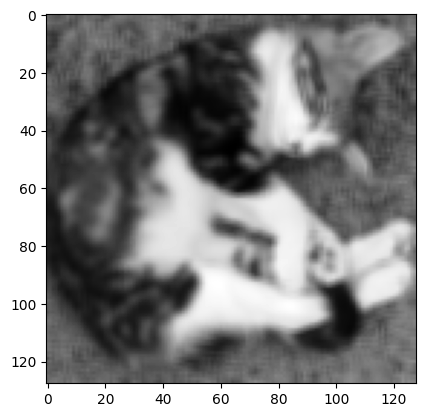

In [7]:
plt.imshow(y)

En résumé, nous avons donc une image, qui se présente comme un tableau carré de taille $128 \times 128$, ce que l'on peut donc modéliser mathématiquement comme une matrice dans $\mathcal{M}_{128}(\mathbb{R})$, ou un vecteur de $\mathbb{R}^{128\times 128}$. Par la suite on préfèrera la vision 'vecteur' que 'matrice'.

## I.2. Flouter est une application linéaire

Intéressons-nous maintenant à la notion de "floutage". Notre image `y` est clairement floue, mais qu'est-ce que cela veut dire?
Pour répondre à cette question, il faut commencer par comprendre comment flouter une image.

In [9]:
from scripts.image import flou

Nous avons maintenant à notre disposition une fonction `flou`, qui prend en entrée une image à $128\times 128$ pixels, et la floute. Il s'agit donc d'une fonction que l'on va noter $\Phi : \mathbb{R}^{128\times 128} \longrightarrow \mathbb{R}^{128\times 128}$.


Il est maintenant temps de la tester, et d'étudier ses propriétés.

**1)** Appliquer la fonction de floutage $\Phi$ à `y`, et afficher le résultat obtenu. Vous afficherez également ce qui se passe lorsque l'on applique 10 fois cette fonction à `y` (autrement dit, on veut visualiser $\Phi^{10}(y)$).

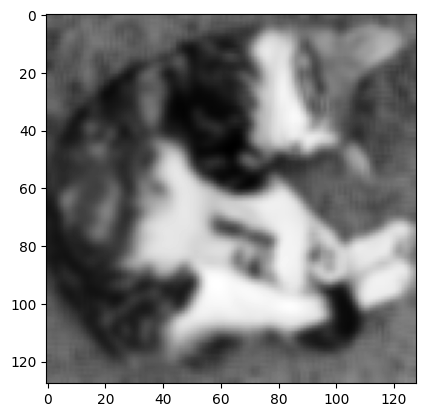

In [10]:
plt.imshow(flou(y))

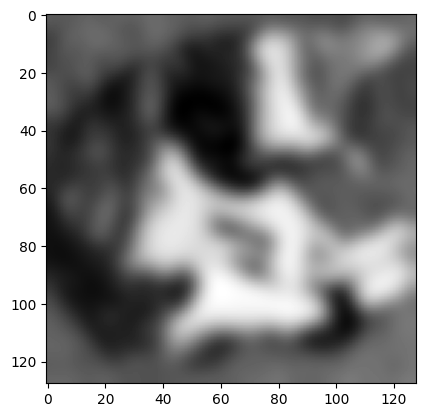

In [11]:
f = y
for _ in range(10):
    f = flou(f)
plt.imshow(f)

**2)** Nous allons maintenant vérifier que l'application de floutage $\Phi$ est ... *linéaire*. Ou plus exactement, nous allons nous en convaincre.

Pour cela, vérifiez que la relation $\Phi(X+Y) = \Phi (X) + \Phi (Y)$ est vérifiée pour des vecteurs aléatoires $X,Y$ dans $\mathbb{R}^{128 \times 128}$.

In [12]:
X = np.random.randn(128,128)
Y = np.random.randn(128,128)

la.norm(flou(X)+flou(Y)-flou(X+Y)) # ok

1.9771196498577974e-14

In [13]:
(flou(X+Y)==flou(X)+flou(Y)).all()

False

**3)** Vérifions que l'application de floutage $\Phi$ est non seulement linéaire, mais est en plus *symétrique*: c'est-à-dire que $\Phi^*=\Phi$. 

Sauf que ... ici $\Phi$ n'est pas une matrice! C'est une application linéaire $\Phi : \mathbb{R}^{128 \times 128} \longrightarrow \mathbb{R}^{128 \times 128}$, et tout ce que l'on peut faire c'est l'évaluer avec la fonction Python `flou`. 

**Du coup il faut calculer la matrice associée à cette aplication linéaire?**

On *pourrait* essayer de calculer sa matrice dans la base canonique. Mais cela donnerait une matrice carrée dont chaque côté serait de taille $128 \times 128 = 16384$, c'est à dire une matrice avec $16384^2 \simeq 2\times 10^8$ coefficients. Sachant que un nombre = un octet, on parle donc ici d'une matrice qui pèse $100$ Mo. Non merci. 

Heureusement, on dispose d'une astuce, qui est : la **propriété de l'adjoint**! Pour rappel, si $u : \mathbb{R}^N \longrightarrow \mathbb{R}^N$ est une application linéaire, alors son application adjointe $u^* : \mathbb{R}^N \longrightarrow \mathbb{R}^N$ est l'unique fonction vérifiant la propriété de l'adjoint :

\begin{equation*}
    (\forall X,Y \in \mathbb{R}^N) \quad \langle u(X),Y \rangle = \langle X, u^*(Y) \rangle.
\end{equation*}

Puisque l'adjoint est l'application linéaire correspondant à la transposée, il nous suffit donc de vérifier que $\Phi^*=\Phi$, c'est-à-dire:

\begin{equation*}
    (\forall X,Y \in \mathbb{R}^{128\times 128}) \quad \langle \Phi(X),Y \rangle = \langle X, \Phi(Y) \rangle.
\end{equation*}

A vous de vérifier ça, en prenant encore une fois des vecteurs aléatoires.

<details>
<summary>Cliquez <b>ici</b> si vous ne trouvez pas comment calculer le produit scalaire.</summary>
Si on fait abstraction de la fonction de floutage, vous devez calculer un produit scalaire $\langle X,Y \rangle $ entre deux tableaux $X$ et $Y$. Pour cela il vous faut 1) multiplier terme à terme les coefficients de ces tableaux 2) faire la somme de toutes ces multiplications. 
    
Vous avez en début d'énoncé les commandes qui vous permettent de faire ces deux opérations.
</details>

In [14]:
X = np.random.randn(128,128)
Y = np.random.randn(128,128)

np.sum(X*flou(Y)) - np.sum(flou(X)*Y)

1.7763568394002505e-14

## I.3 Modélisation du problème 

Nous avons donc sous la main une fonction de floutage $\Phi$ qui s'avère être linéaire, et qui a la propriété de flouter des images.

D'autre part, nous disposons d'une image $y$ qui a visiblement été floutée. Nous pouvons donc raisonablement faire *l'hypothèse* que cette image $y$ a été obtenue à partir d'une certaine image $x$, que l'on ne connait pas, via le processus

$$ \Phi(x) = y$$

Nous devons donc résoudre un système linéaire! On dispose de $\Phi$, de $y$, il nous suffit donc de trouver un $x$ qui satisfait à cette équation.

**Sauf que**

Sauf que comme on l'a déjà vu plus haut, on n'a accès qu'à l'application linaire `flou`, pas sa matrice. Donc hors de question de penser à des choses comme "calculer l'inverse de `flou`" ou appliquer le pivot de Gauss au système.

**Super ... et donc?**

Nous disposons encore d'un outil : l'optimisation! 

En effet, résoudre $\Phi x = y$ est équivalent à trouver $x \in \mathbb{R}^{128\times 128}$ tel que $\Phi x-y = 0$.
Or un vecteur est nul si et seulement si sa *norme* s'annule, donc c'est équivalent à trouver $x$ tel que $\Vert \Phi x - y \Vert =0$.
Et puisque notre norme euclidienne est positive, on voit que c'est encore équivalent à

\begin{equation*}
    \underset{x \in \mathbb{R}^{128\times 128}}{\text{minimiser}} \ \frac{1}{2} \Vert \Phi(x) - y \Vert^2.
\end{equation*}

Comme on va le voir à la fin de ce TP, cette formulation du problème est plus avantageuse puisqu'elle s'écrit sous forme *fonctionnelle*, ce qui correspond exactement à ce que l'on a sous la main : une fonction `flou`.

## II. Algorithme du gradient pour une fonction quadratique

Dans cette section nous allons voir comment minimiser une fonction quadratique de la forme 
\begin{equation}
f(x) = \frac{1}{2}\Vert Ax - b \Vert^2.
\tag{1}
\end{equation}
où $A$ est une  matrice de $\R^{N\times N}$, $b\in \R^N$. Pour cela nous allons utiliser l'**Algorithme du Gradient à Pas Fixe (GPF)**. On rappelle que pour une fonction à gradient $L$-Lipschitzien, cet algorithm s'écrit:

| | | |
|-|-|-|
|(GPF)| On choisit $x_0$ un vecteur de $\R^N$ et $\rho \in ]0,2/L[$ un pas fixe. |
|  | Pour $k\geq 0$ : $x_{k+1}  = x_k  - \rho \nabla f(x_k)$. |

**1)** Définir une matrice $A \in \Mm_{50,100}(\RR)$, et un vecteur $b \in \RR^{50}$, tous deux alétoires. 

Ici, et durant toute la suite du TP, les *vecteurs* devront être considérés comme des matrices sous forme de *colonne*.

In [15]:
b = np.random.randn(50,1)
A = np.random.randn(50,100)

**2)** Rappel du cours/TD: Le gradient de la fonction $f$ en $x$ vaut $\nabla f(x) = A^*(Ax-b)$ et $\nabla^2 f(x) \equiv A^*A$. Calculer $L$, la constante de Lipschitz du gradient de $f$.

In [16]:
L = la.norm(A.T@A,2)

**3.1)** Définir une fonction `algo_gradient` qui:
- prend en arguments une matrice `A`, un vecteur `b`, un point initial `x0`, un pas `rho`, et un nombre d'itérations maximal `itermax`
- applique l'algorithme du gradient à pas constant à $f$, en partant de `x0`, pendant `itermax` itérations
- renvoie le dernier itéré de la suite

In [17]:
def algo_gradient(A, b, x0, rho, itermax):
    x = x0
    for k in range(itermax):
        gradient = A.T @ (A@x-b)
        x = x - rho*gradient
    return x

**3.2)** Vérifier que votre fonction marche bien, en la testant avec $\rho=1/L$, `itermax`$=10^3$ et un point initial de votre choix dans $\RR^{100}$. Vous vérifierez également que la solution `x` ainsi obtenue satisfait $\nabla f(x) \simeq 0$.

In [18]:
rho = 1/L
itermax = 10**3
x0 = np.zeros((100,1))
x = algo_gradient(A, b, x0, rho, itermax)

In [19]:
la.norm(A.T @ (A@x-b))

1.2869893865333744e-14

**3.3)** Vu que l'algorithme a l'air de marcher très bien, on n'a peut être pas besoin de le faire tourner pour toutes les `itermax` itérations: peut être que l'on peut s'arrêter avant. 

Modifier la fonction `algo_gradient` afin que:
- il prenne en nouvel argument: un niveau de tolérance `tol`
- il s'arrête dès lors que $\Vert \nabla f(x) \Vert <$ `tol`
- avant de renvoyer le dernier itéré, il affiche le nombre d'itérations qui ont été effectuées avec `print`

Pour cela, vous pourrez utiliser l'instruction `break` qui, utilisée à l'intérieur d'une boucle, permet de sortir directement de la boucle (voir le petit exemple ci-dessous pour comprendre comment `break` fonctionne en python).

In [20]:
# Exemple de focntionnement pour BREAK
for boucle_externe in [1,2,3]:
    print("Boucle externe numéro "+str(boucle_externe))
    for lettre in "abcde":
        print(lettre)
        if lettre == "c":
            break
    print("La boucle interne s'est arrêtée à : "+lettre)

Boucle externe numéro 1
a
b
c
La boucle interne s'est arrêtée à : c
Boucle externe numéro 2
a
b
c
La boucle interne s'est arrêtée à : c
Boucle externe numéro 3
a
b
c
La boucle interne s'est arrêtée à : c


In [21]:
# Nouvelle version de algo_gradient
def algo_gradient(A, b, x0, rho, itermax, tol):
    x = x0
    gradient = A.T @ (A@x-b)
    for n in range(itermax):
        x = x - rho*gradient
        gradient = A.T @ (A@x-b)
        if la.norm(gradient) < tol:
            break
    print(f"Nombre d'itérations effectuées: {n+1}")
    return x

**3.4)** Tester la nouvelle version de l'algorithme avec les mêmes paramètres qu'à la question **3.2)**, et une tolérance de $10^{-10}$. De combien d'itérations a-t-on besoin? Etait-il nécessaire d'aller jusqu'à 1000 itérations?

In [22]:
rho = 1/L
itermax = 10**3
x0 = np.zeros((100,1))
tol = 1e-10
x = algo_gradient(A, b, x0, rho, itermax, tol)

Nombre d'itérations effectuées: 660


**4)** On souhaite maintenant que l'algorithme aille le **plus vite** possible. Pour cela, on va se servir du cours, qui indique que l'algorithme du gradient à pas fixe converge le plus vite lorsque $\rho = \frac{2}{\mu+L}$, où $\mu$ est la plus petite valeur singlulière de $A^*A$.

**4.1)** Calculer `mu` de deux façons différentes: $\sigma_{min}(A^*A)$ et $\sigma_{min}(A)^2$. Que constatez-vous? Lequel donne un résultat satisfaisant? A votre avis, pourquoi?

In [23]:
la.norm(A,-2)**2
la.norm(A.T@A,-2)
# On voit que le deuxième renvoie un nombre proche de zéro ; il doit donc y avoir des instabilités numériques 
# lors du calcul du produit qui font passer des valeurs propres nulles de A*A à strictement positives.

3.1459996918255766e-16

**4.2)** Utiliser l'algorithme comme à la question **3.4)** en remplaçant le pas $1/L$ par $\frac{2}{\mu+L}$. Observer le nombre d'itérations qu'il faut maintenant.

In [24]:
mu = la.norm(A,-2)**2
rho = 2/(mu+L)
itermax = 10**3
x0 = np.zeros((100,1))
tol = 1e-10
x = algo_gradient(A, b, x0, rho, itermax, tol)

Nombre d'itérations effectuées: 340


**4.3)** A votre avis est-ce que ce problème est bien conditionné?

In [25]:
L/mu

27.686012019890132

# III. Résolution du problème de défloutage

Revenons à notre problème de défloutage. Comme on l'a vu, il nous suffit de minimiser la fonction quadratique $\Vert \Phi(x) - y \Vert^2$, où $\Phi$= `flou` et $y$ est notre image floutée.

In [27]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
plt.set_cmap('gray') # Fixe la colormap à 'gray' pour afficher les images
y = np.load('data/photo.npy')
from scripts.image import flou

<Figure size 640x480 with 0 Axes>

**1)** Récupérer le code de la fonction `algo_gradient` afin d'écrire une fonction `défloutage` qui:

- prend en arguments une image `y`, un point initial `x0`, un pas `rho`, un nombre d'itérations maximal `itermax`, un niveau de tolérance `tol`
- applique l'algorithme du gradient à pas constant à $f$, en partant de `x0`, pendant `itermax` itérations
- s'arrête dès lors que $\Vert \nabla f(x) \Vert <$ `tol`
- renvoie le dernier itéré de la suite
- avant de renvoyer le dernier itéré, elle affiche le nombre d'itérations qui ont été effectuées avec `print`

Le travail ici consiste essentiellement à remplacer la matrice $A$ par l'application linéaire de floutage (qui est symétrique, rappelons-le).

In [28]:
def defloutage(y, x0, rho, itermax, tol):
    x = x0
    gradient = flou(flou(x)-y)
    for n in range(itermax):
        x = x - rho*gradient
        gradient = flou(flou(x)-y)
        if la.norm(gradient) < tol:
            break
    print(f"Nombre d'itérations effectuées: {n+1}")
    return x  

**2)** Tester cette fonction avec `itermax=2000`, une tolérance de $10^{-4}$, et un point initial de votre choix. On ne connait pas la constante de Lipschitz de $\nabla f$, donc il va falloir choisir un pas au doigt mouillé (mais pas trop grand!): par exemple `rho = 0.01`.

In [29]:
x0 = np.zeros((128,128))
rho = 0.01
itermax=2000
tol = 10**(-4)
x = defloutage(y, x0, rho, itermax, tol)

Nombre d'itérations effectuées: 2000


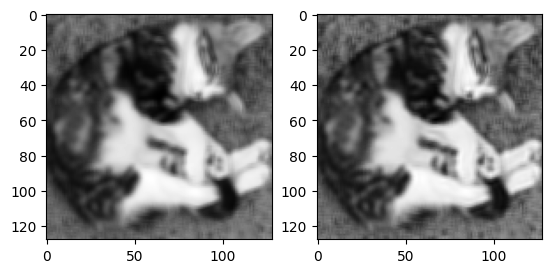

In [30]:
# pour afficher deux images x et y
_ = plt.figure(dpi=100)
_ = plt.subplot(1,2,1)
plt.imshow(y) # l'image floutée
_ = plt.subplot(1,2,2)
plt.imshow(x) # l'image obtenue par l'algorithme

**3)** Cette histoire de pas nous embête un peu... 

Idéalement on voudrait prendre quelque chose comme $\frac{1}{L}$, où $L$ est la norme de la Hessienne de $f$, qui est ici $\Phi \circ \Phi$. Autrement dit, $L = \Vert \Phi \circ \Phi \Vert = \Vert \Phi \Vert^2$.
Or, encore une fois, on ne peut pas utiliser les fonctions de Python pour lui demander de nous calculer cette norme $\Vert \Phi \Vert$ puisque on n'a pas accès à la matrice, mais seulement à la fonction. Néanmoins on va pouvoir utiliser une astuce!

**La méthode des puissances itérées**

Cette [méthode](https://en.wikipedia.org/wiki/Power_iteration) est très simple et permet de calculer de manière approximative la norme $\Vert \Phi \Vert$ d'un opérateur $\Phi$, sans avoir à passer par une diagonalisation. C'est le coeur de l'algorithme Pagerank utilisé par Google à ses débuts!

Voici comment s'écrit cette méthode:

\begin{equation*}
\text{Choisir $u_0 \in \mathbb{R}^{128 \times 128}$ aléatoirement, puis } \  
    \begin{cases}
        v_k = \Phi u_k \\
        u_{k+1} = \frac{v_k}{\Vert v_k \Vert}\\
        \lambda_{k+1} = \langle \Phi u_{k+1}, u_{k+1} \rangle
    \end{cases}
\end{equation*}

et la théorie prédit que $\lambda_k$ converge vers $\Vert \Phi \Vert$.

A vous d'écrire une petite boucle  qui implémente cet algorithme sur une centaine d'itérations, afin d'obtenir $\lambda \simeq \Vert \Phi \Vert$.

In [31]:
u = np.random.randn(128,128)
for _ in range(100):
    v = flou(u)
    u = v/la.norm(v)
    lmbda = np.sum( flou(u)*u )
lmbda

0.5489400355541416

**4)** Reprendre la question **2)** avec cette fois-ci un pas $\frac{1}{L}$, où $L = \Vert \Phi \Vert^2$. Comparez le nombre d'itérations effectués cette fois, et comparez la qualité de la solution.

In [32]:
x0 = np.zeros((128,128))
rho = 1/lmbda**2
itermax=10000
tol = 10**(-4)
x = defloutage(y, x0, rho, itermax, tol)

Nombre d'itérations effectuées: 1507


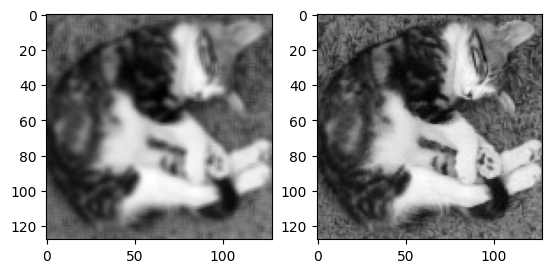

In [33]:
_ = plt.figure(dpi=100)
_ = plt.subplot(1,2,1)
plt.imshow(y) # l'image floutée
_ = plt.subplot(1,2,2)
plt.imshow(x) # l'image obtenue par l'algorithme

# IV. Pour aller plus loin. Méthode du gradient : Théorie vs. Pratique (bonus)

Dans cette ultime section, nous revenons dans le contexte de la section II, et nous nous intéressons à la *vitesse de convergence* de l'algorithme du gradient.
En effet, la théorie prédit certaines vitesses, et il serait intéressant de vérifier si dans notre cadre cela est vrai en pratique (ou pas).


In [34]:
b = np.random.randn(50,1)
A = np.random.randn(50,100)
L = la.norm(A,2)**2
mu = la.norm(A,-2)**2

Le cours prédit que 
\begin{eqnarray}
f(x_{k+1}) - \inf f & \leq & \theta^{2k} \  (f(x_k) - \inf f),
\end{eqnarray}

où $\theta = (L - \mu)/L$ si $\rho = 1/L$, et $\theta = (L- \mu)/(L+\mu)$ si $\rho = 2/(L + \mu)$.
On va vérifier si ces vitesses sont respectées.

**1)** Modifier la fonction `algo_gradient` afin que:
- il renvoie en plus une liste `suite` qui contient pour chaque itéré $x$ de la suite la valeur $f(x)$.

In [35]:
# Nouvelle version de algo_gradient
def algo_gradient(A, b, x0, rho, itermax, tol):
    suite = []
    x = x0
    suite.append( 0.5*la.norm(A@x-b)**2 )
    gradient = A.T @ (A@x-b)
    
    for n in range(itermax):
        x = x - rho*gradient
        gradient = A.T @ (A@x-b)
        suite.append( 0.5*la.norm(A@x-b)**2 )
        if la.norm(gradient) < tol:
            break
    print(f"Nombre d'itérations effectuées: {n+1}")
    return x, suite

**2)** Utiliser cet algorithme avec une grande précision pour calculer $\inf f$.

In [36]:
rho = 1/L
itermax = 10**3
x0 = np.zeros((100,1))
tol = 1e-12
x, suite = algo_gradient(A, b, x0, rho, itermax, tol)

inf = suite[-1]
inf

Nombre d'itérations effectuées: 744


4.9128477329006516e-26

In [37]:
inf = 0

**3)** Faire tourner l'algorithme du gradient avec $\rho  =1/L$, et construire deux listes :
- `val` qui contient les valeurs $f(x_k) - \inf f$
- `val_theorie` qui contient la borne supérieure $\theta^{2k} (f(x_0) - \inf f)$.


In [38]:
val = suite

theta = (L-mu)/L
val_theorie = theta**(2*np.arange(len(suite))) * ( 0.5*la.norm( A@x0 - b,2)**2 )

**4)** Vérifier si la décroissance des valeurs respecte la thérorie : on tracera deux courbes correspondant à `val` et `val_theorie` en échelle logarithmique. Qu'en pensez-vous?

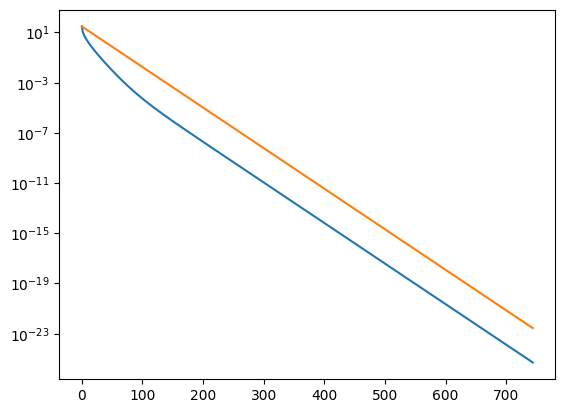

In [39]:
_=plt.figure()
_=plt.plot(val)
_=plt.plot(val_theorie)
plt.yscale('log')

**5)** Reprendre ces deux dernières questions avec cette fois-ci un pas $\rho = 2/(L+\mu)$.

In [40]:
rho = 2/(L+mu)
itermax = 10**3
x0 = np.zeros((100,1))
tol = 1e-10
x, suite = algo_gradient(A, b, x0, rho, itermax, tol)

Nombre d'itérations effectuées: 362


In [41]:
val = suite

theta = (L-mu)/(L+mu)
val_theorie = theta**(2*np.arange(len(suite))) * ( 0.5*la.norm( A@x0 - b,2)**2 )

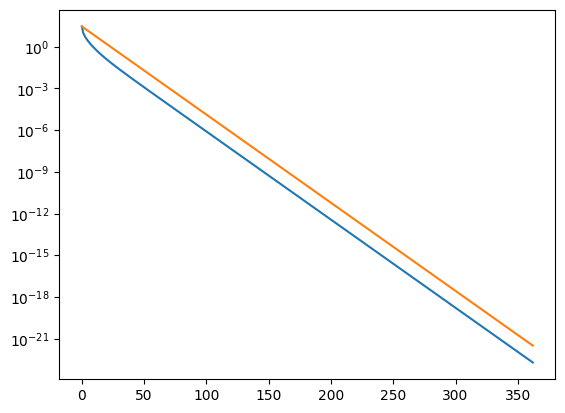

In [42]:
_=plt.figure()
_=plt.plot(val)
_=plt.plot(val_theorie)
plt.yscale('log')

**Quelques commentaires sur ce TP:**

- On a discuté du fait qu'afficher un tableau se faisait selon la règle 0=noir, 1=blanc. Mais en fait ce choix est totalement arbitraire! On pourrait tout a fait dire que 0=bleu et 1=rose! Rien ne nous empêche de la faire, et cela se fait en passant un argument `cmap` (colormap=carte de couleurs) à la fonction `plt.imshow(y, cmap=...)`. Essayez par exemple `cmap=cool`! Vous pouvez trouver une longue liste de cartes de couleurs sur cette [page](https://matplotlib.org/stable/tutorials/colors/colormaps.html).
- Que se passe-t-il lorsque le tableau a des valeurs en dehors de $[0,1]$? En général les valeurs sont noramlisées et ramenées à un intervalle $[0,1]$, ou $[0,255]$.
- Comment fait-on pour traiter des images en couleurs? Une image en couleurs est en général la combinaison de 3 tableaux, chacun représentant une intensité non pas de gris mais respectivement en Rouge, Vert, Bleu. Autrement dit, derrière chacun des pixels se cache un triplet (R,V,B). Si la question de la manipulation des images vous intéresse, je vous recommande cet [article](https://images.math.cnrs.fr/Le-traitement-numerique-des-images.html).
- Comment fonctionne l'opération de floutage? Pour flouter une image, on fait simplement des moyennes locales : en chaque pixel on regarde la valeur des pixels voisins, on en fait la moyenne, et on passe au pixel suivant. Ce qui est intéressant est que l'on peut écrire cette opération comme une *convolution*, qui se calcule alors aisément avec la transformée de Fourier. Si vous voulez plus de détails demandez à votre prof d'Intégration!